<a href="https://colab.research.google.com/github/bekku/deeplearning/blob/master/%5B%E4%BF%9D%E5%AD%98%E7%89%88%5DUBI_69_verfin_%E8%BF%BD%E5%8A%A0%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jan 26 03:24:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    49W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **import編**

In [ ]:
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import random
# !pip install deap
# from deap import base, creator, tools
import pandas as pd
!pip install Gpyopt
import GPyOpt


from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                # (0.4914,0.4822,0.4465),(0.247,0.243,0.261)
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                # (0.4914,0.4822,0.4465),(0.247,0.243,0.261)
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
    )

    return {'train': train_loader, 'test': test_loader}

torch.cuda.is_available()
import os
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
SEED = 0
set_seed(SEED)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
loader = load_cifar10()
test_original=list(loader['test'])
print(len(test_original[0]),len(test_original[0][0]),len(test_original[0][1]),len(test_original))


loader['test'] = test_original[:38]
loader['test_final'] = test_original[38:]

Files already downloaded and verified
Files already downloaded and verified
2 128 128 79


In [ ]:
len(list(loader['test']))

38

# **教師モデルの設定**

In [ ]:
class VGG16(nn.Module):
    def __init__(self): # , num_classes):
        super(VGG16, self).__init__()
        num_classes=10
        set_seed(SEED)

        self.block1_output = nn.Sequential (
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block2_output = nn.Sequential (
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block3_output = nn.Sequential (
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block4_output = nn.Sequential (
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block5_output = nn.Sequential (
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  #512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 32 ),  #4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(32, num_classes),  #4096
        )

    def forward(self, x):
        x = self.block1_output(x)
        # print(x.size())
        x = self.block2_output(x)
        # print(x.size())
        x = self.block3_output(x)
        # print(x.size())
        x = self.block4_output(x)
        # print(x.size())
        x = self.block5_output(x)
        # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)
        return x
VGG16

__main__.VGG16

# **教師モデル出力（s_max・a_max定義）**

In [ ]:
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/2020_秋_TERM/2020_12_終月/VGG16_model.pth')
Tnet.load_state_dict(param)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet.to(device)
s_max=0
t1 = time.perf_counter()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = Tnet(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
t2 = time.perf_counter()
s_max += t2-t1
a_max = float(correct/ (38*128))
print(a_max)
print(f"経過時間：{s_max}")


a_max = 0.8780838815789473
s_max = 0.3776551340000651
s_max = 0.44755143700000644

0.8780838815789473
経過時間：0.44555853299999626


In [ ]:
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/2020_秋_TERM/2020_12_終月/VGG16_model.pth')
Tnet.load_state_dict(param)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet.to(device)
s_max=0
t1 = time.perf_counter()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = Tnet(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
t2 = time.perf_counter()
s_max += t2-t1
a_max = float(correct/ (38*128))
print(a_max)
print(f"経過時間：{s_max}")


a_max = 0.8780838815789473
s_max = 0.3776551340000651
s_max = 0.44755143700000644

0.8780838815789473
経過時間：0.36505864800000154


In [ ]:
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/2020_秋_TERM/2020_12_終月/VGG16_model.pth')
Tnet.load_state_dict(param)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet.to(device)
s_max=0
correct = 0
t1 = time.perf_counter()
with torch.no_grad():
    for images, labels in loader['test_final']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = Tnet(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
t2 = time.perf_counter()
s_max = t2-t1
a_max = float(correct/ (10000 - 38*128))
print(a_max)
print(f"経過時間：{s_max}")


a_max = 0.8825934579439252
s_max = 0.39026910500001577

0.8825934579439252
経過時間：0.39026910500001577


In [ ]:
len(loader["test_final"])

41

In [ ]:
for i in loader["test_final"]:
  print(len(i[0]))
print(10000 - 38*128)
40*128+16

128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
16
5136


5136

# **VGG生成モデル②**

入力[n_1, n_2, , , ,  n_N]

VGG16(正確にはconvが13層)を生成しモデルが作られる。

In [ ]:
class CreateVGG_2(torch.nn.Module):
    def __init__(self, VGG_model_list):
        super(CreateVGG_2, self).__init__()
        self.count = 0
        set_seed(SEED)

        PRE_FILTER = 3
        for i in range(len(VGG_model_list)):
            if VGG_model_list[i]!=0:
                FILTER = VGG_model_list[i]
                self._modules["fc"+str(i+1)] = nn.Sequential (
                nn.Conv2d(PRE_FILTER, FILTER, kernel_size=3, padding=1),
                nn.BatchNorm2d(FILTER),
                nn.ReLU(inplace=True),
                )
                PRE_FILTER=FILTER

        self.classifier = nn.Sequential(
            nn.Linear(PRE_FILTER, PRE_FILTER), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER, PRE_FILTER//2 ), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER//2, 10), 
        )
        self.pool = torch.nn.MaxPool2d(2, 2) 
        

    def forward(self, x):
        for i in range(1,14):
            if "fc"+str(i) in self._modules:
                x = f.relu(self._modules["fc"+str(i)](x))
                # print(x.size())
            if i==2 or i==4 or i==7 or i==10 or i==13:
                x = self.pool(x)
                # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)
        # print(x.size())
        return x
        # x = x/T
        # return f.log_softmax(x,dim=1)

# **温度付きcross_entropyの損失関数の定義**

In [ ]:
class T_S_Closs_entropy(torch.nn.Module):
    def __init__(self):
        super(T_S_Closs_entropy, self).__init__()
        self.criterion = torch.nn.CrossEntropyLoss()
        set_seed(SEED)

    def forward(self, q, p, label, T, a=0.9):
        #教師モデルをp、生徒モデルq、正解ラベル、温度が引数となる
        loss = self.criterion(q,label)

        p = p/T
        q = q/T
        # qのみlogの中に入ります。
        q = f.log_softmax(q,dim=1)
        p = f.softmax(p,dim=1)
        loss_LKD = torch.mul(p,q)
        loss_LKD = -torch.sum(loss_LKD)
        loss_LKD = loss_LKD/len(p)
        loss_LKD = loss_LKD * T * T

        loss = a*loss
        loss_LKD = (1-a)*loss_LKD

        loss = loss + loss_LKD
        return loss

# **速度と精度の評価関数(最大化予定)**

In [ ]:
def speed_acc_normalization(spe_max,spe_min,spe,acc_max,acc_min,acc,rt=0.5):
    if spe_min<=spe<=spe_max:
        speed_normalization = rt*((spe_max-spe) - spe_min) / ( (spe_max - spe_min) )
    elif spe_min>spe:
        speed_normalization=1*rt
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = (1-rt)*(acc - acc_min) / ( (acc_max - acc_min) )
    elif acc_min>acc:
        accuracy_normalization=0
    else:
        accuracy_normalization=1*(1-rt)
    print("--------------------------------------------------------------------------------")
    print("速度:{} ,精度:{}".format(spe,acc))
    print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    print("評価指標:{}".format(speed_normalization + accuracy_normalization))
    print("--------------------------------------------------------------------------------")

    return speed_normalization + accuracy_normalization

In [ ]:
def speed_acc_normalization_init(spe_max,spe_min,spe,acc_max,acc_min,acc,rt=0.5):
    if spe_min<=spe<=spe_max:
        speed_normalization = rt*((spe_max-spe) - spe_min) / ( (spe_max - spe_min) )
    elif spe_min>spe:
        speed_normalization=1*rt
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = (1-rt)*(acc - acc_min) / ( (acc_max - acc_min) )
    elif acc_min>acc:
        accuracy_normalization=0
    else:
        accuracy_normalization=1*(1-rt)
    # print("--------------------------------------------------------------------------------")
    # print("速度:{} ,精度:{}".format(spe,acc))
    # print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    # print("評価指標:{}".format(speed_normalization + accuracy_normalization))
    # print("--------------------------------------------------------------------------------")

    return speed_normalization + accuracy_normalization

In [ ]:
def speed_acc_normalization_harmonic_mean(spe_max,spe_min,spe,acc_max,acc_min,acc,rt=1):
    if spe_min<=spe<=spe_max:
        speed_normalization = ((spe_max-spe - spe_min) / (spe_max - spe_min))/rt
    elif spe_min>spe:
        speed_normalization = 1/rt
    else:
        speed_normalization = 0
        
    if acc_min<=acc<=acc_max:
        accuracy_normalization = rt*((acc - acc_min) / (acc_max - acc_min))
    elif acc_min>acc:
        accuracy_normalization = rt*( (acc - 0) / (acc_max -0))
    else:
        accuracy_normalization = rt*1

    if speed_normalization + accuracy_normalization == 0:
      ans = 0
    else:
      ans = (2 * speed_normalization * accuracy_normalization)/(speed_normalization + accuracy_normalization)
    print("--------------------------------------------------------------------------------")
    print("速度:{} ,精度:{}".format(spe,acc))
    print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    print("評価指標:{}".format((ans)))
    print("--------------------------------------------------------------------------------")

    return (ans)

In [ ]:
def speed_acc_normalization_harmonic_mean_init(spe_max,spe_min,spe,acc_max,acc_min,acc,rt=1):
    # adjus = -1

    if spe_min<=spe<=spe_max:
        speed_normalization = ((spe_max-spe - spe_min) / (spe_max - spe_min))/rt
        # adjus += 1
    elif spe_min>spe:
        speed_normalization = 1/rt
    else:
        speed_normalization = 0

    if acc_min<=acc<=acc_max:
        accuracy_normalization = rt*((acc - acc_min) / (acc_max - acc_min))
        # adjus += 1
    elif acc_min>acc:
        accuracy_normalization = rt*( (acc - 0) / (acc_max -0))
    else:
        accuracy_normalization = rt*1

    if speed_normalization + accuracy_normalization == 0:
      ans = 0
    else:
      ans = (2 * speed_normalization * accuracy_normalization)/(speed_normalization + accuracy_normalization)

    # ans += adjus
    # print("--------------------------------------------------------------------------------")
    # print("速度:{} ,精度:{}".format(spe,acc))
    # print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    # print("評価指標:{}".format((ans)))
    # print("--------------------------------------------------------------------------------")

    return (ans)

In [ ]:
0.7247121710526315
mini_ = 0.7
a_max = 0.8780838815789473
s_max = 0.3776551340000651
rt_i = 5
elapsed_time =  0.0370651

speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,mini_,0.7247121710526315,rt_i)

--------------------------------------------------------------------------------
速度:0.0370651 ,精度:0.7247121710526315
速度評価値:0.18037092751399292 ,精度評価値:0.693835141999538
評価指標:0.2863116431435909
--------------------------------------------------------------------------------


0.2863116431435909

# **蒸留追加学習**

In [ ]:
def knowldge_distillation(T_net,gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    set_seed(SEED)
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])
    global history_midle_to_mini
    history_midle_to_mini = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    T_net.to(device)

    criterion = T_S_Closs_entropy()
    
    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None

        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            data_one = T_net(images)

            #(p, q, label, T)
            loss = criterion(output, data_one, labels, 4)
            loss.backward()
            optimizer.step()
        history_midle_to_mini['train_loss'].append(loss.item())
        if e%60==0:
            print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))

        net.eval()
        t1 = time.perf_counter()
        correct = 0
        with torch.no_grad():
            for images, labels in loader['test_final']:
                images = images.to(device) 
                labels = labels.to(device)
                #　蒸留モデルは、推論時は温度を1に戻します。
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000-38*128))
        t2 = time.perf_counter()
        if e%60==0:
            print('test accuracy:{}'.format(acc))
        history_midle_to_mini['test_acc'].append(acc)
    elapsed_time = t2 - t1
    speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc, rt = 1)
    path = "/content/gdrive/My Drive/2020_秋_TERM/2021_1/学習済みモデル"+str("".join(map(str,gane)))+".pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

     # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_midle_to_mini['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_midle_to_mini['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    # return speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc)

0 0 0 0 0 0 0 0 0 0 0 3 0
Training log: 1 epoch：Loss: 4.989349842071533
test accuracy:0.24610591900311526
Training log: 61 epoch：Loss: 5.136345863342285
test accuracy:0.3808411214953271
Training log: 121 epoch：Loss: 4.624336242675781
test accuracy:0.4110202492211838
Training log: 181 epoch：Loss: 4.475802421569824
test accuracy:0.4137461059190031
--------------------------------------------------------------------------------
速度:0.049654477999865776 ,精度:0.4172507788161994
速度評価値:0.872768616926867 ,精度評価値:0.4727553496580631
評価指標:0.6133016474066667
--------------------------------------------------------------------------------


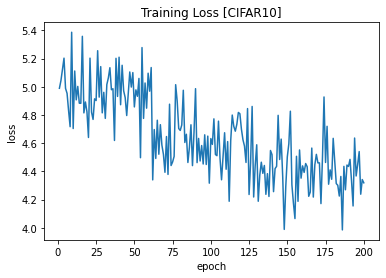

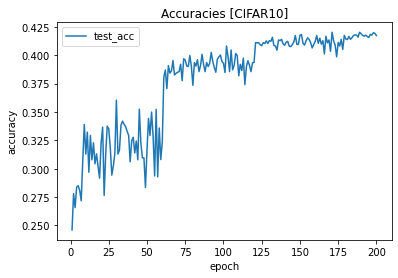

In [ ]:
knowldge_distillation(Tnet, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0], 200)

In [ ]:
model_sets = [
  [2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5], # 1/2
  [3, 2, 3, 5, 0, 3, 0, 0, 4, 0, 3, 0, 4], # GA
  [1, 2, 3, 3, 0, 2, 0, 3, 0, 3, 0, 0, 6], # BO
  [3, 2, 4, 0, 4, 5, 6, 2, 3, 5, 5, 3, 0], # 1/100
  [3, 2, 3, 3, 0, 0, 0, 4, 3, 3, 2, 4, 0], # 1/10
  [0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 4, 4], # 3
  [0, 0, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0], # 10
]

In [ ]:
for model_gane in model_sets:
    knowldge_distillation(Tnet, model_gane, 200)

In [ ]:
aaaaa=[[1, 0, 0, 0, 0, 2, 0, 0, 2, 4, 0, 0, 0, 0],
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 5, 0],
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 5, 0],
[0, 1, 1, 0, 0, 3, 3, 4, 0, 2, 0, 3, 0, 0],
[1, 2, 0, 2, 0, 0, 4, 0, 4, 0, 2, 4, 4, 0],
[2, 0, 0, 0, 2, 0, 3, 0, 0, 3, 3, 6, 0, 0],
[0, 2, 1, 0, 0, 0, 0, 4, 0, 5, 0, 6, 5, 0]]

In [ ]:
for model_gane in aaaaa:
    knowldge_distillation(Tnet, model_gane, 200)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class CreateResNet(nn.Module):
    def __init__(self, block, model_list, num_classes=10):
        super(CreateResNet, self).__init__()
        for i in model_list:
            if i!=0:
                self.in_planes = i
                break
        # self.in_planes = model_list[0]

        Fill_dis = [[],[],[],[]]
        num_blocks = [0,0,0,0]

        for Fill in model_list[1:5]:
            if Fill != 0:
                Fill_dis[0].append(Fill)
                num_blocks[0] += 1

        for Fill in model_list[5:9]:
            if Fill != 0:
                Fill_dis[1].append(Fill)
                num_blocks[1] += 1

        for Fill in model_list[9:13]:
            if Fill != 0:
                Fill_dis[2].append(Fill)
                num_blocks[2] += 1

        for Fill in model_list[13:17]:
            if Fill != 0:
                Fill_dis[3].append(Fill)
                num_blocks[3] += 1

        last_fill = 1000
        for i in range(len(model_list)-1,-1,-1):
            if model_list[i]!=0:
              last_fill = model_list[i]
              break


        # self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7,stride=2, padding=3, bias=False)
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, Fill_dis[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, Fill_dis[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, Fill_dis[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, Fill_dis[3], num_blocks[3], stride=2)
        self.linear = nn.Linear(last_fill, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        if num_blocks!=0:
            strides = [stride] + [1]*(num_blocks-1)
        else:
            strides = []
        layers = []
        for i,stride in enumerate(strides):
            layers.append(block(self.in_planes, planes[i], stride))
            self.in_planes = planes[i] * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x,T=1):
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = out/T
        return f.log_softmax(out,dim=1)


def ResNet18():
    # return ResNet(BasicBlock, [2, 2, 2, 2])
    return CreateResNet(BasicBlock,[3, 3, 3, 0, 0, 4, 4, 0, 0, 5, 5, 0, 0, 6, 6, 0, 0])

def ResNet34():
    # return ResNet(BasicBlock, [3, 4, 6, 3])
    return CreateResNet(BasicBlock,[64,64,64,64,0,128,128,128,128,256,256,256,256,256,256,512,512,512,0])

def test():
    net = ResNet18()
    net.to(device)
    y = net(torch.randn(128, 3, 32, 32).to(device))
    print(y.size())

test()
# summary(CreateResNet(BasicBlock,[64,64,64,0,0,128,128,0,0,256,256,0,0,512,512,0,0]),(3,32,32))
# summary(CreateResNet(BasicBlock,[64,32,32,0,0,64,64,0,0,128,128,0,0,256,256,0,0]),(3,32,32))


torch.Size([128, 10])


In [ ]:
def knowldge_distillation_res(T_net,gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    set_seed(SEED)
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        model_gane.append(gane_number[i])
    net: torch.nn.Module = CreateResNet(BasicBlock, model_gane)
    global history_midle_to_mini
    history_midle_to_mini = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }
    net.to(device)
    T_net.to(device)

    criterion = T_S_Closs_entropy()
    
    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None

        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            data_one = T_net(images)

            #(p, q, label, T)
            loss = criterion(output, data_one, labels, 4)
            loss.backward()
            optimizer.step()
        history_midle_to_mini['train_loss'].append(loss.item())
        if e%60==0:
            print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))

        net.eval()
        t1 = time.perf_counter()
        correct = 0
        with torch.no_grad():
            for images, labels in loader['test_final']:
                images = images.to(device) 
                labels = labels.to(device)
                #　蒸留モデルは、推論時は温度を1に戻します。
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000-38*128))
        t2 = time.perf_counter()
        if e%60==0:
            print('test accuracy:{}'.format(acc))
        history_midle_to_mini['test_acc'].append(acc)
    elapsed_time = t2 - t1
    speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc, rt = 1)
    path = "/content/gdrive/My Drive/2020_秋_TERM/2021_1/RES学習済みモデル"+str("".join(map(str,gane)))+".pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

     # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_midle_to_mini['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_midle_to_mini['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    # return speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc)

In [ ]:
model_sets2 = [
               [3, 3, 3, 0, 0, 4, 4, 0, 0, 5, 5, 0, 0, 6, 6, 0, 0],
               [4, 0, 0, 1, 0, 0, 0, 4, 1, 4, 2, 2, 0, 0, 4, 0, 1, 0]
]

3 3 3 0 0 4 4 0 0 5 5 0 0 6 6 0 0
Training log: 1 epoch：Loss: 3.6148905754089355
test accuracy:0.4776090342679128
Training log: 61 epoch：Loss: 1.1702439785003662
test accuracy:0.844626168224299
Training log: 121 epoch：Loss: 1.246541142463684
test accuracy:0.8424844236760125
Training log: 181 epoch：Loss: 1.301332950592041
test accuracy:0.8594236760124611
--------------------------------------------------------------------------------
速度:0.26657973199962726 ,精度:0.8576713395638629
速度評価値:0.4514472415846947 ,精度評価値:0.9717626296051181
評価指標:0.6164931363827096
--------------------------------------------------------------------------------
4 0 0 1 0 0 0 4 1 4 2 2 0 0 4 0 1 0
Training log: 1 epoch：Loss: 3.5521819591522217
test accuracy:0.5654205607476636
Training log: 61 epoch：Loss: 1.3509961366653442
test accuracy:0.8329439252336449
Training log: 121 epoch：Loss: 1.2588251829147339
test accuracy:0.8345015576323987
Training log: 181 epoch：Loss: 1.2975943088531494
test accuracy:0.8448208722741433


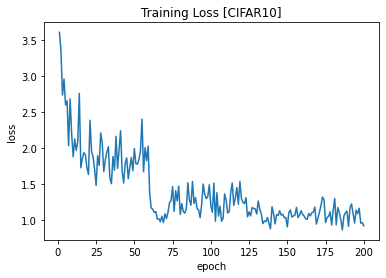

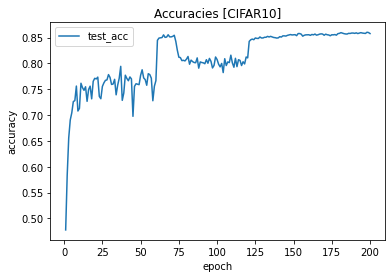

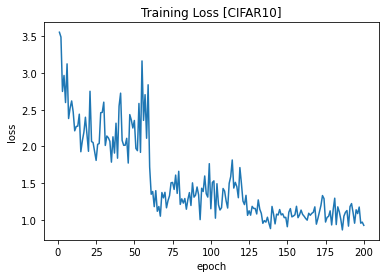

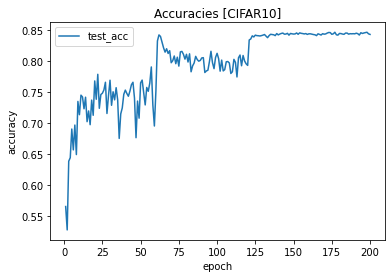

In [ ]:
for model_gane in model_sets2:
    knowldge_distillation_res(Tnet, model_gane, 200)

# **実際の数値検証ゾーン**

In [ ]:
model_sets = [
  [2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5], # 1/2
  [3, 2, 3, 5, 0, 3, 0, 0, 4, 0, 3, 0, 4], # GA
  [1, 2, 3, 3, 0, 2, 0, 3, 0, 3, 0, 0, 6], # BO
  [3, 2, 4, 0, 4, 5, 6, 2, 3, 5, 5, 3, 0], # 1/100
  [3, 2, 3, 3, 0, 0, 0, 4, 3, 3, 2, 4, 0], # 1/10
  [0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 4, 4], # 3
  [0, 0, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0], # 10
]
model_sets2=[[1, 0, 0, 0, 0, 2, 0, 0, 2, 4, 0, 0, 0, 0],
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 5, 0],
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 5, 0],
[0, 1, 1, 0, 0, 3, 3, 4, 0, 2, 0, 3, 0, 0],
[1, 2, 0, 2, 0, 0, 4, 0, 4, 0, 2, 4, 4, 0],
[2, 0, 0, 0, 2, 0, 3, 0, 0, 3, 3, 6, 0, 0],
[0, 2, 1, 0, 0, 0, 0, 4, 0, 5, 0, 6, 5, 0]]

In [ ]:
resmodel_sets = [
               [3, 3, 3, 0, 0, 4, 4, 0, 0, 5, 5, 0, 0, 6, 6, 0, 0],
               [4, 0, 0, 1, 0, 0, 0, 4, 1, 4, 2, 2, 0, 0, 4, 0, 1, 0]
]

In [ ]:
def keisoku(gane):
    set_seed(SEED)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])
    net: torch.nn.Module = CreateVGG_2(model_gane)
    param = torch.load('/content/gdrive/My Drive/2020_秋_TERM/2021_1/学習済みモデル'+str("".join(map(str,gane)))+'.pth')
    net.load_state_dict(param)
    net.to(device)
    t1 = time.perf_counter()
    correct = 0
    with torch.no_grad():
        for images, labels in loader['test_final']:
            images = images.to(device) 
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    t2 = time.perf_counter()
    acc = float(correct/ (10000 - 38*128))
    elapsed_time = t2 - t1
    speed_acc_normalization_harmonic_mean(s_max, 0, elapsed_time, a_max, 0, acc, rt = 1)


In [ ]:

a_max = 0.8825934579439252

s_max = 0.39026910500001577

In [ ]:
for gane_ in model_sets:
    keisoku(gane_)

2 2 3 3 4 4 4 5 5 5 5 5 5
--------------------------------------------------------------------------------
速度:0.20032956099998955 ,精度:0.8806464174454829
速度評価値:0.4866886503865545 ,精度評価値:0.9977939554379
評価指標:0.6542548786096847
--------------------------------------------------------------------------------
3 2 3 5 0 3 0 0 4 0 3 0 4
--------------------------------------------------------------------------------
速度:0.16207478400008313 ,精度:0.8970015576323987
速度評価値:0.584710186064878 ,精度評価値:1
評価指標:0.7379395818951845
--------------------------------------------------------------------------------
1 2 3 3 0 2 0 3 0 3 0 0 6
--------------------------------------------------------------------------------
速度:0.1046600939999962 ,精度:0.8726635514018691
速度評価値:0.7318258282320554 ,精度評価値:0.9887491727332892
評価指標:0.8411050745748612
--------------------------------------------------------------------------------
3 2 4 0 4 5 6 2 3 5 5 3 0
---------------------------------------------------------------------

In [ ]:
for gane_ in model_sets2:
    keisoku(gane_)

1 0 0 0 0 2 0 0 2 4 0 0 0 0
--------------------------------------------------------------------------------
速度:0.0774612470000875 ,精度:0.7969236760124611
速度評価値:0.8015183728158949 ,精度評価値:0.9029340392675933
評価指標:0.8492090677136432
--------------------------------------------------------------------------------
1 0 0 1 0 0 0 0 0 0 2 2 5 0
--------------------------------------------------------------------------------
速度:0.09391183599996111 ,精度:0.8337227414330218
速度評価値:0.7593664607400646 ,精度評価値:0.9446282814912862
評価指標:0.841926347603269
--------------------------------------------------------------------------------
1 0 0 1 0 0 0 0 0 0 2 3 5 0
--------------------------------------------------------------------------------
速度:0.07989659999998366 ,精度:0.8491043613707165
速度評価値:0.7952781837548211 ,精度評価値:0.9620560335318774
評価指標:0.8707531754533371
--------------------------------------------------------------------------------
0 1 1 0 0 3 3 4 0 2 0 3 0 0
-----------------------------------------

In [ ]:
keisoku([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0])

0 0 0 0 0 0 0 0 0 0 0 3 0
--------------------------------------------------------------------------------
速度:0.05248361099984322 ,精度:0.4137461059190031
速度評価値:0.8655194317781288 ,精度評価値:0.4687844694462828
評価指標:0.6081703984365673
--------------------------------------------------------------------------------


In [ ]:
_def reskeisoku(gane):
    set_seed(SEED)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        model_gane.append(gane_number[i])
    net: torch.nn.Module = CreateResNet(BasicBlock, model_gane)
    param = torch.load("/content/gdrive/My Drive/2020_秋_TERM/2021_1/RES学習済みモデル"+str("".join(map(str,gane)))+".pth") # 保存先pathの設定
    net.load_state_dict(param)
    net.to(device)
    correct = 0
    t1 = time.perf_counter()
    with torch.no_grad():
        for images, labels in loader['test_final']:
            images = images.to(device) 
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    t2 = time.perf_counter()
    acc = float(correct/ (10000 - 38*128))
    elapsed_time = t2 - t1
    speed_acc_normalization_harmonic_mean(s_max, 0, elapsed_time, a_max, 0, acc, rt = 1)


In [ ]:
for gane_ in resmodel_sets:
    reskeisoku(gane_)

3 3 3 0 0 4 4 0 0 5 5 0 0 6 6 0 0
--------------------------------------------------------------------------------
速度:0.261570997999911 ,精度:0.8533878504672897
速度評価値:0.3297676022807379 ,精度評価値:0.9669093315684977
評価指標:0.49180387738938175
--------------------------------------------------------------------------------
4 0 0 1 0 0 0 4 1 4 2 2 0 0 4 0 1 0
--------------------------------------------------------------------------------
速度:0.21801469000001816 ,精度:0.8452102803738317
速度評価値:0.44137343385147193 ,精度評価値:0.9576439444076771
評価指標:0.6042506729633905
--------------------------------------------------------------------------------


In [ ]:
[4, 0, 0, 1, 0, 0, 0, 4, 1, 4, 2, 2, 0, 0, 4, 0, 1, 0]
--------------------------------------------------------------------------------
速度:0.12664463600049203 ,精度:0.7771381578947368
速度評価値:0.6646553307535065 ,精度評価値:0.8850386326387263
評価指標:0.759176532918115  

# **VGG16top学習**

In [ ]:
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                (0.4914,0.4822,0.4465),(0.247,0.243,0.261)
                                # [0.5, 0.5, 0.5],  # RGB 平均
                                # [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                (0.4914,0.4822,0.4465),(0.247,0.243,0.261)
                                # [0.5, 0.5, 0.5],  # RGB 平均
                                # [0.5, 0.5, 0.5]   # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
    )

    return {'train': train_loader, 'test': test_loader}

loader = load_cifar10()

def VGG16_learning():
    # 入力された乗数から、本当のモデルのノード数とする。
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net: torch.nn.Module =  VGG16()
    net.to(device)
    criterion = torch.nn.CrossEntropyLoss() 
    # optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9, weight_decay = 0.008)

    global history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    lr_set = 0.1
    epoch = 200
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    for e in range(epoch):
        # if e!=0 and e%60==0:
            # lr_set *= 0.2
        # optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        history['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))
      
        net.eval()

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['test']):
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000))
        print('test accuracy:{}'.format(acc))
        history['test_acc'].append(acc)
        scheduler.step()
        print(optimizer)
        
    #====== 保存 =======
    path = "/content/gdrive/My Drive/2020_秋_TERM/2021_1/VGG16_model_top.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

Files already downloaded and verified
Files already downloaded and verified


Training log: 1 epoch：Loss: 1.9567464590072632
test accuracy:0.1853
SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.09999383162408304
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Training log: 2 epoch：Loss: 1.7548927068710327
test accuracy:0.241
SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.09997532801828658
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Training log: 3 epoch：Loss: 1.69918954372406
test accuracy:0.2635
SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.09994449374809851
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Training log: 4 epoch：Loss: 1.7008607387542725
test accuracy:0.3601
SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.09990133642141359
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Training log: 5 epoch：Loss: 1.6803516149520874
test accuracy:0.3484
SGD (
Parameter Group 0
    dampening: 0
    in

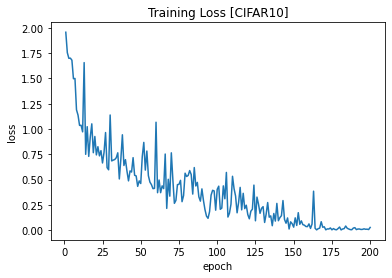

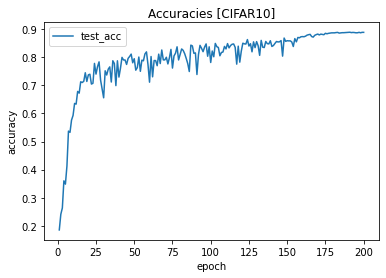

In [ ]:
VGG16_learning()

# **ガウス過程部分**

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler

In [ ]:
X_fin = np.atleast_2d([num/100 for num in rt_list]).T
y_fin = np.atleast_2d([initial_Y[num][0] for num in ans_list]).T

In [ ]:
# plot_X = np.atleast_2d(np.linspace(50, 89, 1000)).T
plot_X = np.atleast_2d(np.linspace(0.69, 0.88, 1000)).T
scaler_y = StandardScaler().fit(y_fin)

kernel = ConstantKernel() * RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0)
gpr.fit(X_fin, scaler_y.transform(y_fin))

print(gpr.kernel_)

In [ ]:
# plot_Xに対する平均および標準偏差の予測
pred_mu, pred_sigma = gpr.predict(plot_X, return_std=True)
pred_mu = scaler_y.inverse_transform(pred_mu)
pred_sigma = pred_sigma.reshape(-1, 1) * scaler_y.scale_

# 各xに対する95%信頼区間を表示
fig = plt.figure(figsize=(8, 4))
plt.plot(X_fin, y_fin, 'r.', markersize=16)
plt.plot(plot_X, pred_mu, 'b')
# データが正規分布に従う場合、95%信頼区間は平均から標準偏差の1.96倍以内の区間となる
plt.fill_between(plot_X.squeeze(), (pred_mu - 1.9600 * pred_sigma).squeeze(), (pred_mu + 1.9600 * pred_sigma).squeeze())
plt.xlabel('accu', fontsize=16)
plt.ylabel('time', fontsize=16)
# plt.xlim(0,100)
# plt.ylim(0,400)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor # ランダムフォレスト回帰用
from sklearn.linear_model import LogisticRegression


plot_X = np.atleast_2d(np.linspace(0.69, 0.88, 100)).T
# ランダムフォレスト実行
rfr = RandomForestRegressor(5) # インスタンスの生成　木の数を100個に指定
rfr.fit(X_fin, y_fin)            # 学習実行
yfit = rfr.predict(plot_X) # 予測実行

# 結果比較用に実際の値を取得。
ytrue = y_fin # xfitを波発生関数に食わせて、その結果を取得

# 結果確認
plt.figure(figsize = (8,4))
plt.plot(plot_X, yfit, '-r')                # 予測値のplot
plt.plot(X_fin, ytrue, 'o', alpha = 0.5)  # 正解値のplot